In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv


# 1. Imports & basic setup


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



# 2. Load data


In [3]:
train_path = "/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv"
test_path = "/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv"
sample_sub_path = "/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_sub_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("Sample submission shape:", sample_submission.shape)

print("\nTrain columns:", train.columns.tolist())
train.head()


Train shape: (7000, 6)
Test shape : (1700, 5)
Sample submission shape: (1700, 2)

Train columns: ['id', 'phrase', 'feature_1', 'feature_2', 'feature_3', 'sentiment']


,id,phrase,feature_1,feature_2,feature_3,sentiment
0,0,It may as well be called `` Jar-Jar Binks : Th...,14.0,5.0,7.0,0
1,1,You have to see it .,6.0,1.0,NaN,2
2,2,... either you 're willing to go with this cla...,16.0,0.0,6.0,1
3,3,Watching Harris ham it up while physically and...,37.0,NaN,3.0,1
4,4,Pete 's screenplay manages to find that real n...,20.0,1.0,4.0,2


# 3. Identify text & target columns + data types


In [4]:
 
TEXT_COL = "phrase"      # movie review text
TARGET_COL = "sentiment" # label (0–4)
ID_COL = "id"

print("TEXT_COL:", TEXT_COL)
print("TARGET_COL:", TARGET_COL)
print("ID_COL:", ID_COL)

print("\n--- Train info() ---")
train.info()

print("\n--- Test info() ---")
test.info()

 

TEXT_COL: phrase
TARGET_COL: sentiment
ID_COL: id

--- Train info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7000 non-null   int64  
 1   phrase     7000 non-null   object 
 2   feature_1  6088 non-null   float64
 3   feature_2  5896 non-null   float64
 4   feature_3  5938 non-null   float64
 5   sentiment  7000 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 328.3+ KB

--- Test info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1700 non-null   int64  
 1   phrase     1700 non-null   object 
 2   feature_1  1478 non-null   float64
 3   feature_2  1382 non-null   float64
 4   feature_3  1610 non-null   float64
dtypes: float64(3), int64(1), o

#  4. Descriptive statistics of numerical columns


In [5]:
 
numeric_original = ["feature_1", "feature_2", "feature_3"]
print("\nNumeric columns:", numeric_original)

train[numeric_original].describe()



Numeric columns: ['feature_1', 'feature_2', 'feature_3']


,feature_1,feature_2,feature_3
count,6088.000000,5896.000000,5938.000000
mean,19.025624,1.996608,3.334119
std,9.303562,1.634858,2.321154
min,1.000000,0.000000,0.000000
25%,12.000000,1.000000,2.000000
50%,18.000000,1.000000,3.000000
75%,25.000000,3.000000,4.000000
max,52.000000,19.000000,19.000000


# 5. Missing values: identify & handle


In [6]:
 

print("Missing values in TRAIN:")
print(train.isnull().sum())

print("\nMissing values in TEST:")
print(test.isnull().sum())

# Handle missing text by filling with empty string
train[TEXT_COL] = train[TEXT_COL].fillna("")
test[TEXT_COL]  = test[TEXT_COL].fillna("")

# Drop rows with missing target (if any)
before_drop = train.shape[0]
train = train.dropna(subset=[TARGET_COL])
after_drop = train.shape[0]

print(f"\nDropped {before_drop - after_drop} rows with missing target (if any).")

print("\nMissing values in TRAIN after handling:")
print(train.isnull().sum())

print("\nMissing values in TEST after handling:")
print(test.isnull().sum())

 

Missing values in TRAIN:
id              0
phrase          0
feature_1     912
feature_2    1104
feature_3    1062
sentiment       0
dtype: int64

Missing values in TEST:
id             0
phrase         0
feature_1    222
feature_2    318
feature_3     90
dtype: int64

Dropped 0 rows with missing target (if any).

Missing values in TRAIN after handling:
id              0
phrase          0
feature_1     912
feature_2    1104
feature_3    1062
sentiment       0
dtype: int64

Missing values in TEST after handling:
id             0
phrase         0
feature_1    222
feature_2    318
feature_3     90
dtype: int64


#  6. Duplicates: identify & handle


In [7]:
 
# Full-row duplicates
dup_full = train.duplicated().sum()
print(f"\nNumber of fully duplicated rows in TRAIN: {dup_full}")

# Duplicate phrases (based only on text)
dup_phrase = train.duplicated(subset=[TEXT_COL]).sum()
print(f"Number of duplicated phrases in TRAIN (same text): {dup_phrase}")

# Drop full duplicates
train = train.drop_duplicates()
print("TRAIN shape after dropping duplicate rows:", train.shape)



Number of fully duplicated rows in TRAIN: 0
Number of duplicated phrases in TRAIN (same text): 177
TRAIN shape after dropping duplicate rows: (7000, 6)


# 7. Feature engineering - text length features


In [8]:
  
def add_text_length_features(df, text_col):
    df = df.copy()
    df["review_length_chars"] = df[text_col].apply(len)
    df["review_length_words"] = df[text_col].apply(lambda x: len(str(x).split()))
    return df

train = add_text_length_features(train, TEXT_COL)
test  = add_text_length_features(test, TEXT_COL)

numeric_engineered = ["review_length_chars", "review_length_words"]

# Combine original + engineered numeric columns
numeric_cols = ["feature_1", "feature_2", "feature_3"] + numeric_engineered

print("Numeric columns used:", numeric_cols)
display(train[numeric_cols].describe())



Numeric columns used: ['feature_1', 'feature_2', 'feature_3', 'review_length_chars', 'review_length_words']


,feature_1,feature_2,feature_3,review_length_chars,review_length_words
count,6088.000000,5896.000000,5938.000000,7000.000000,7000.000000
mean,19.025624,1.996608,3.334119,102.051571,19.024857
std,9.303562,1.634858,2.321154,51.732906,9.313818
min,1.000000,0.000000,0.000000,4.000000,1.000000
25%,12.000000,1.000000,2.000000,61.000000,12.000000
50%,18.000000,1.000000,3.000000,97.000000,18.000000
75%,25.000000,3.000000,4.000000,137.000000,25.000000
max,52.000000,19.000000,19.000000,283.000000,52.000000


# 8. Outlier detection & handling (IQR, on engineered features)


In [9]:
 

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

for col in numeric_engineered:
    lb, ub = detect_outliers_iqr(train[col])
    outliers = ((train[col] < lb) | (train[col] > ub)).sum()
    print(f"{col}: lower={lb:.2f}, upper={ub:.2f}, outliers={outliers}")

# Instead of dropping, we clip extreme values to keep all rows but reduce impact
for col in numeric_engineered:
    lb, ub = detect_outliers_iqr(train[col])
    train[col] = np.clip(train[col], lb, ub)
    test[col]  = np.clip(test[col], lb, ub)

print("\nNumeric summary AFTER clipping engineered features (IQR bounds):")
display(train[numeric_engineered].describe())


review_length_chars: lower=-53.00, upper=251.00, outliers=26
review_length_words: lower=-7.50, upper=44.50, outliers=51

Numeric summary AFTER clipping engineered features (IQR bounds):


,review_length_chars,review_length_words
count,7000.000000,7000.000000
mean,102.018000,19.004786
std,51.631402,9.253889
min,4.000000,1.000000
25%,61.000000,12.000000
50%,97.000000,18.000000
75%,137.000000,25.000000
max,251.000000,44.500000


# 9. Visualizations (at least 3) + Insights


# 9.1 Sentiment class distribution


Sentiment value counts:
sentiment
0    2684
1    1344
2    2972
Name: count, dtype: int64


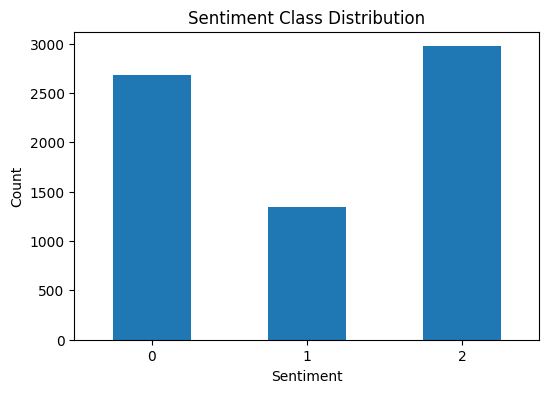

In [10]:
import matplotlib.pyplot as plt

sent_counts = train[TARGET_COL].value_counts().sort_index()
print("Sentiment value counts:")
print(sent_counts)

plt.figure(figsize=(6,4))
sent_counts.plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()




# 9.2 Histogram of review length (characters)


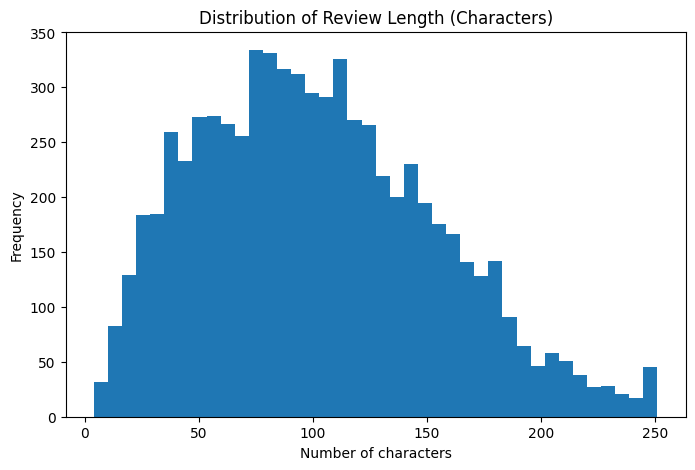

In [11]:
plt.figure(figsize=(8,5))
plt.hist(train["review_length_chars"], bins=40)
plt.title("Distribution of Review Length (Characters)")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()


# 9.3 Boxplot: review length (words) by sentiment


<Figure size 800x500 with 0 Axes>

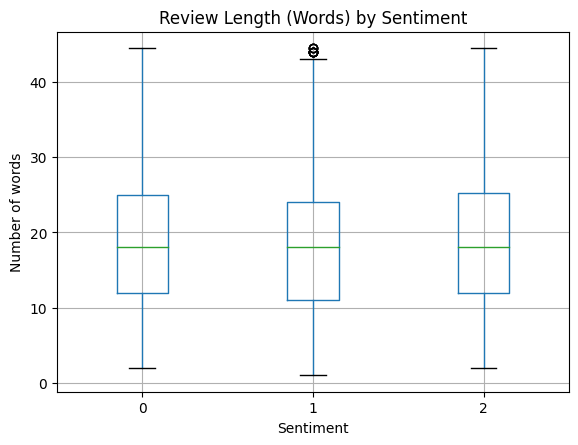

In [12]:
plt.figure(figsize=(8,5))
train.boxplot(column="review_length_words", by=TARGET_COL)
plt.title("Review Length (Words) by Sentiment")
plt.suptitle("")  # remove automatic title
plt.xlabel("Sentiment")
plt.ylabel("Number of words")
plt.show()


# 10. Train-validation split


In [13]:
 
# Features = text + numeric columns
X = train[[TEXT_COL] + numeric_cols].copy()
y = train[TARGET_COL].copy()

print("X columns:", X.columns.tolist())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)



X columns: ['phrase', 'feature_1', 'feature_2', 'feature_3', 'review_length_chars', 'review_length_words']
X_train shape: (5600, 6)
X_valid shape: (1400, 6)


# 11. Preprocessing: TF-IDF for text + scaling numeric features


In [14]:
 
# Text transformer: word-level TF-IDF (we'll add stronger models later)
text_transformer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),   # unigrams + bigrams
    max_df=0.9,
    min_df=2
)

# Numeric transformer: impute missing + standardize
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),
        ("num", numeric_transformer, numeric_cols)
    ]
)

print("✅ Preprocessor defined (TF-IDF for text, scaling for numeric).")


✅ Preprocessor defined (TF-IDF for text, scaling for numeric).


# 12. Helper function to train & evaluate models


In [15]:
  
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid, results_list):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average="weighted")
    print(f"\nModel: {name}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-score (weighted): {f1:.4f}")
    results_list.append({
        "model": name,
        "accuracy": acc,
        "f1_weighted": f1
    })
    return model, y_pred



# 13. Define at least 7 different models


In [16]:
 
results_list = []
fitted_models = {}
preds_valid = {}

# 1. Logistic Regression
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, multi_class="auto"))
])

# 2. Linear SVC
pipe_lsvc = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC(random_state=RANDOM_STATE))
])

# 3. Multinomial Naive Bayes (text only, NB expects non-negative data)
pipe_nb = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=2
    )),
    ("clf", MultinomialNB())
])

# 4. SGDClassifier (linear model with log-loss)
pipe_sgd = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SGDClassifier(loss="log_loss", random_state=RANDOM_STATE))
])

# 5. RandomForest
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# 6. GradientBoosting
pipe_gb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# 7. XGBoost (multi-class)
num_classes = train[TARGET_COL].nunique()
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# 8. PassiveAggressive (extra)
pipe_pa = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", PassiveAggressiveClassifier(random_state=RANDOM_STATE))
])

models_to_run = [
    ("Logistic Regression", pipe_lr, False),
    ("Linear SVC",         pipe_lsvc, False),
    ("Multinomial NB",     pipe_nb,  True),  # text-only
    ("SGDClassifier",      pipe_sgd, False),
    ("RandomForest",       pipe_rf,  False),
    ("GradientBoosting",   pipe_gb,  False),
    ("XGBoost",            pipe_xgb, False),
    ("PassiveAggressive",  pipe_pa,  False)
]


# 14. Fit and evaluate each model


In [17]:
for name, model, text_only in models_to_run:
    if text_only:
        model_trained, y_pred = evaluate_model(
            name,
            model,
            X_train[TEXT_COL],
            y_train,
            X_valid[TEXT_COL],
            y_valid,
            results_list
        )
    else:
        model_trained, y_pred = evaluate_model(
            name,
            model,
            X_train,
            y_train,
            X_valid,
            y_valid,
            results_list
        )
    fitted_models[name] = model_trained
    preds_valid[name] = y_pred

results_df = pd.DataFrame(results_list).sort_values(by="accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df



Model: Logistic Regression
  Accuracy: 0.6171
  F1-score (weighted): 0.5721

Model: Linear SVC
  Accuracy: 0.5979
  F1-score (weighted): 0.5799

Model: Multinomial NB
  Accuracy: 0.6250
  F1-score (weighted): 0.5599

Model: SGDClassifier
  Accuracy: 0.6214
  F1-score (weighted): 0.5757

Model: RandomForest
  Accuracy: 0.5700
  F1-score (weighted): 0.5286

Model: GradientBoosting
  Accuracy: 0.5207
  F1-score (weighted): 0.4582

Model: XGBoost
  Accuracy: 0.5629
  F1-score (weighted): 0.5277

Model: PassiveAggressive
  Accuracy: 0.5779
  F1-score (weighted): 0.5722


,model,accuracy,f1_weighted
0,Multinomial NB,0.625000,0.559896
1,SGDClassifier,0.621429,0.575724
2,Logistic Regression,0.617143,0.572053
3,Linear SVC,0.597857,0.579852
4,PassiveAggressive,0.577857,0.572219
5,RandomForest,0.570000,0.528577
6,XGBoost,0.562857,0.527669
7,GradientBoosting,0.520714,0.458249


# 15. Hyperparameter Tuning — Logistic Regression, LinearSVC, XGBoost


In [18]:
# 15.1 Logistic Regression tuning
param_grid_lr = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0],
    "clf__class_weight": [None, "balanced"],
    "clf__penalty": ["l2"]
}

pipe_lr_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=3000,
        random_state=RANDOM_STATE,
        multi_class="auto"
    ))
])

grid_lr = GridSearchCV(
    estimator=pipe_lr_base,
    param_grid=param_grid_lr,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
print("\nBest LogisticRegression params:", grid_lr.best_params_)
print("Best LogisticRegression CV accuracy:", grid_lr.best_score_)

y_pred_lr = grid_lr.predict(X_valid)
acc_lr = accuracy_score(y_valid, y_pred_lr)
f1_lr = f1_score(y_valid, y_pred_lr, average="weighted")
print(f"LogReg tuned - Val Accuracy: {acc_lr:.4f}, F1: {f1_lr:.4f}")


# 15.2 Linear SVC tuning
param_grid_lsvc = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}

pipe_lsvc_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC(random_state=RANDOM_STATE))
])

grid_lsvc = GridSearchCV(
    estimator=pipe_lsvc_base,
    param_grid=param_grid_lsvc,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lsvc.fit(X_train, y_train)
print("\nBest LinearSVC params:", grid_lsvc.best_params_)
print("Best LinearSVC CV accuracy:", grid_lsvc.best_score_)

y_pred_lsvc = grid_lsvc.predict(X_valid)
acc_lsvc = accuracy_score(y_valid, y_pred_lsvc)
f1_lsvc = f1_score(y_valid, y_pred_lsvc, average="weighted")
print(f"LinearSVC tuned - Val Accuracy: {acc_lsvc:.4f}, F1: {f1_lsvc:.4f}")



# 15.3 XGBoost tuning (keep grid small for speed)
param_grid_xgb = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [4, 6],
    "clf__learning_rate": [0.05, 0.1]
}

pipe_xgb_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb.XGBClassifier(
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

grid_xgb = GridSearchCV(
    estimator=pipe_xgb_base,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print("\nBest XGB params:", grid_xgb.best_params_)
print("Best XGB CV accuracy:", grid_xgb.best_score_)

y_pred_xgb = grid_xgb.predict(X_valid)
acc_xgb = accuracy_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb, average="weighted")
print(f"XGB tuned - Val Accuracy: {acc_xgb:.4f}, F1: {f1_xgb:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best LogisticRegression params: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best LogisticRegression CV accuracy: 0.6117857142857144
LogReg tuned - Val Accuracy: 0.6171, F1: 0.5721
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best LinearSVC params: {'clf__C': 0.25}
Best LinearSVC CV accuracy: 0.6101785714285713
LinearSVC tuned - Val Accuracy: 0.6264, F1: 0.5882
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300}
Best XGB CV accuracy: 0.5375016289580811
XGB tuned - Val Accuracy: 0.5629, F1: 0.5277


# 16. Comparison of model performances (base + tuned)


In [19]:
  
comparison_rows = []

# Base models (from results_df)
for _, row in results_df.iterrows():
    comparison_rows.append({
        "model": row["model"] + " (base)",
        "accuracy": row["accuracy"],
        "f1_weighted": row["f1_weighted"]
    })

# Tuned models
comparison_rows.append({
    "model": "Logistic Regression (tuned)",
    "accuracy": acc_lr,
    "f1_weighted": f1_lr
})

comparison_rows.append({
    "model": "Linear SVC (tuned)",
    "accuracy": acc_lsvc,
    "f1_weighted": f1_lsvc
})

comparison_rows.append({
    "model": "XGBoost (tuned)",
    "accuracy": acc_xgb,
    "f1_weighted": f1_xgb
})

comparison_df = pd.DataFrame(comparison_rows).sort_values(by="accuracy", ascending=False)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df


,model,accuracy,f1_weighted
0,Linear SVC (tuned),0.626429,0.588161
1,Multinomial NB (base),0.625000,0.559896
2,SGDClassifier (base),0.621429,0.575724
3,Logistic Regression (base),0.617143,0.572053
4,Logistic Regression (tuned),0.617143,0.572053
5,Linear SVC (base),0.597857,0.579852
6,PassiveAggressive (base),0.577857,0.572219
7,RandomForest (base),0.570000,0.528577
8,XGBoost (base),0.562857,0.527669
9,XGBoost (tuned),0.562857,0.527669


# 17. Extra Model: Character n-gram TF-IDF + Logistic Regression


In [20]:
  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

char_vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=200000
)

pipe_char_lr = Pipeline(steps=[
    ("tfidf", char_vectorizer),
    ("clf", LogisticRegression(
        max_iter=4000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

# Train on text-only split
pipe_char_lr.fit(X_train[TEXT_COL], y_train)

# Validate
y_pred_char = pipe_char_lr.predict(X_valid[TEXT_COL])

acc_char = accuracy_score(y_valid, y_pred_char)
f1_char  = f1_score(y_valid, y_pred_char, average="weighted")

print("🔥 CHAR-NGRAM Logistic Regression VALIDATION ACCURACY:", acc_char)
print("🔥 CHAR-NGRAM Logistic Regression VALIDATION F1:", f1_char)


🔥 CHAR-NGRAM Logistic Regression VALIDATION ACCURACY: 0.6421428571428571
🔥 CHAR-NGRAM Logistic Regression VALIDATION F1: 0.5949032961086532


# 18. FINAL KAGGLE SUBMISSION — CHAR N-GRAM LOGISTIC REGRESSION


In [21]:
 
# 1) Train best model on FULL training data (text only)
pipe_char_lr.fit(train[TEXT_COL], train[TARGET_COL])

# 2) Predict on test data (text only)
test_predictions = pipe_char_lr.predict(test[TEXT_COL])

print("Test predictions length:", len(test_predictions))
print("Sample submission length:", len(sample_submission))

# 3) Build submission in EXACT same format as sample_submission
submission = sample_submission.copy()

# Safest way: replace ONLY the second column (predictions column)
submission.iloc[:, 1] = test_predictions

print("\nSubmission head:")
print(submission.head())
print("\nSubmission shape:", submission.shape)

# 4) Save submission file
submission.to_csv("submission.csv", index=False)
print("\n✅ FINAL submission.csv saved successfully!")


Test predictions length: 1700
Sample submission length: 1700

Submission head:
   id  sentiment
0   0          0
1   1          2
2   2          2
3   3          2
4   4          0

Submission shape: (1700, 2)

✅ FINAL submission.csv saved successfully!
